# A Simple Fashion Classifier

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt
import random

## Load data

In [2]:
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset, Dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# wrapper to apply separate transforms to training and test datasets
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, i):
        img, label = self.base_dataset[self.indices[i]]
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.indices)

In [3]:
data_dir = './data/fashion_labeled/'

# ImageFolder automatically assigns labels to subfolders
dataset = ImageFolder(root= data_dir, transform = None)

# apply image transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=0.3),
    transforms.ColorJitter(
        brightness = 0.1, 
        contrast = 0.1,
        saturation = 0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# train/validation/test split
train_size = int(0.8*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - val_size - train_size

train_indices, val_indices, test_indices = random_split(
    range(len(dataset)),
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

train_dataset = TransformDataset(dataset, train_indices.indices, train_transform)
val_dataset = TransformDataset(dataset, val_indices.indices, test_transform)
test_dataset = TransformDataset(dataset, test_indices.indices, test_transform)

### weighted sampler for class imbalance

In [4]:
from collections import Counter

labels = [label for _, label in train_dataset]
label_counts = Counter(labels)
print(label_counts)

# to fix class imab
class_weights = {label: 1.0 / count for label, count in label_counts.items()}

sample_weights = [class_weights[label] for label in labels]
weights = torch.tensor(sample_weights)

# create the sampler
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(weights, num_samples = len(weights), replacement=True)

Counter({0: 50, 1: 31})


### dataloader

In [5]:
# use dataloader
trainloader = DataLoader(train_dataset, batch_size = 4, sampler = sampler)
valloader = DataLoader(val_dataset, batch_size = 4, shuffle = False)
testloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

In [6]:
# spot check that trainloader is now balanced
images, labels = next(iter(trainloader))

label_counts = Counter(labels.tolist())
label_counts

Counter({1: 3, 0: 1})

### visualize the data

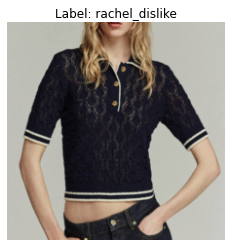

In [7]:
img_tensor, label = random.choice(train_dataset)

def imshow(img_tensor, label = None):
    # unnormalize
    img = img_tensor*0.5 + 0.5
    img = img.numpy().transpose((1,2,0))
    if label is not None:
        plt.title(f"Label: {dataset.classes[label]}")
    plt.axis('off')
    plt.imshow(img)

imshow(img_tensor, label)

## CNN model

In [8]:
class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            # output is 16x112x112
            
            nn.Conv2d(16, 32, kernel_size = 5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2,2),
            # output is 32x54x54
            
            nn.Conv2d(32, 64, kernel_size = 5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d(8)
            # output is 64x8x8
        )
           
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 120),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(120, 84),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(84,2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [9]:
# a more complicated ResNet to play around with
class FashionResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = self.conv_block(in_channels, 64)
        # 64x224x224
        self.conv2 = self.conv_block(64, 128, pool = True)
        # 128x112x112
        
        self.res1 = nn.Sequential(self.conv_block(128,128), self.conv_block(128,128))
        # 128x112x112
        
        self.conv3 = self.conv_block(128,256, pool=True)
        # 128x52x52

        self.conv4 = self.conv_block(256, 512, pool = True)
        # 512x25x25
        
        self.res2 = nn.Sequential(self.conv_block(512,512), self.conv_block(512,512))
        # 512x21x21
        
        self.avg_pool = nn.AdaptiveAvgPool2d((4,4))
        # 512x4x4
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*4*4, 128),
            nn.ReLU(),
            nn.Linear(128, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    
    def conv_block(self, in_channels, out_channels, kernel_size = 3, pool=False):
        
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        
        if pool:
            layers.append(nn.MaxPool2d(2))
            
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + x
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.res2(x) + x
        x = self.avg_pool(x)
        x = self.classifier(x)
        return x

## Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [11]:
def gradient_monitor(named_params):
    total_norm = 0.0
    for name, param in named_params:
        if param.grad is not None:
            total_norm += param.grad.norm(2)**2
        if param.grad.norm().item() > 10:
            print("EXPLODING")
            print(name, param.grad.norm(2))
        if param.grad.norm().item() < 1e-8 and "weight" in name:
            print("VANISHING")
            print(name, param.grad.norm(2))
    total_norm = total_norm**0.5
    if total_norm > 10:
        print(f"Exploding gradients global norm {total_norm:.1f}")
    elif total_norm < 1e-6:
        print(f"Vanishing gradients global norm {total_norm:.1f}")

In [12]:
def model_eval(model, loader, criterion, results = False):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    model_results = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # store validation loss and accuracy
            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            like_probs = probs[:,1]
            correct += (pred == labels).sum().item()
            total += labels.size(0)
            if results:
                for i in range(len(inputs)):
                    model_results.append([inputs[i], labels[i], pred[i], like_probs[i].item()])
    avg_val_loss = val_loss / len(valloader)
    val_acc = correct / total
    
    return avg_val_loss, val_acc, model_results

In [13]:
model_name = "fashion_cnn"

model = FashionClassifier()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer, mode = "min", factor = 0.5, patience=2, verbose=True)

num_epochs = 10

In [14]:
# set up TensorBoard to log training data and look at helpful visualizations
# you may need to pip install tensorboard

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'runs/{model_name}')

# run tensorboard --logdir=runs in this directory
# and then click on the localhost link to view the dashboard

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

losses = []
epoch_losses = []

# training loop
for epoch in range(num_epochs):
    # ------- training -------
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # clip gradients before optimizer step
        torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm = 1.0)
        optimizer.step()
        
        # store running loss and accuracy
        losses.append(loss.item())
        train_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        
        # monitor gradients
        gradient_monitor(model.named_parameters())
        
    # log avg train loss per epoch
    avg_train_loss = train_loss / len(trainloader)
    epoch_losses.append(avg_train_loss)
    train_acc = correct / total
    
    # ------- validation -------
    # to tune the learning rate
    avg_val_loss, val_acc, val_results = model_eval(model, valloader, criterion, results = False)
    
    # decrease learning rate if needed
    scheduler.step(avg_val_loss)
    
     # ----- TensorBoard logging -----
    writer.add_scalar("training loss", avg_train_loss, epoch)
    writer.add_scalar("validation loss", avg_val_loss, epoch)
    writer.add_scalar("training accuracy", train_acc, epoch)
    writer.add_scalar("validation accuracy", val_acc, epoch)
    writer.add_scalar("learning rate", optimizer.param_groups[0]['lr'], epoch)
    
    # ----- print logging -----
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {avg_val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print("-" * 40)
    
writer.close()

Epoch 1/10
Train Loss: 0.8989, Train Acc: 0.5185
Val Loss:   0.7258, Val Acc:   0.3000
----------------------------------------
Epoch 2/10
Train Loss: 0.8066, Train Acc: 0.5309
Val Loss:   0.9364, Val Acc:   0.5000
----------------------------------------
Epoch 3/10
Train Loss: 0.6797, Train Acc: 0.6543
Val Loss:   0.8826, Val Acc:   0.4000
----------------------------------------
Epoch 00004: reducing learning rate of group 0 to 5.0000e-04.
Epoch 4/10
Train Loss: 0.8069, Train Acc: 0.6173
Val Loss:   0.9377, Val Acc:   0.5000
----------------------------------------
Epoch 5/10
Train Loss: 0.5616, Train Acc: 0.7531
Val Loss:   0.8461, Val Acc:   0.3000
----------------------------------------


In [ ]:
# save model
torch.save(model.state_dict(),f"{model_name}_weights.pth")

In [ ]:
plt.plot(losses)
plt.title("training loss over batches")

In [ ]:
plt.plot(epoch_losses)
plt.title("avg training loss over epochs")

## Test

In [ ]:
test_loss, test_acc, test_results = model_eval(model, testloader, criterion, results = True)
print(f"Testset size {len(test_results)}")
print(f"Test Loss:   {test_loss:.2f}, Test Acc:   {test_acc:.2f}")

In [ ]:
# visualize incorrect predictions
wrong = [entry for entry in test_results if entry[1] != entry[2]]
class_names = dataset.classes

plt.figure(figsize=(12, 12))
i = 0
for img, label, pred, prob in wrong:
    plt.subplot(-(-len(wrong)//4), 4, i+1)
    imshow(img)
    plt.title(f"Pred: {class_names[pred]} / True: {class_names[label]}", fontsize=10)
    i += 1

plt.tight_layout()
plt.show()

## Inference

In [ ]:
def plot_results(results):
    plt.figure(figsize=(12, 12))
    i = 0
    for img, label, pred, like_prob in results:
        plt.subplot(-(-len(results)//4), 4, i+1)
        imshow(img)
        plt.title(f"Pred: {class_names[pred]}, p_like: {like_prob:.2f}", fontsize=10)
        i += 1

    plt.tight_layout()
    plt.show()

In [ ]:
inference_model = FashionClassifier()
inference_model.load_state_dict(torch.load(f"{model_name}_weights.pth"))

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

inference_dataset = datasets.ImageFolder(root = './data/fashion_unlabeled/', transform=transform)
inferenceloader = DataLoader(inference_dataset, batch_size = 4, shuffle=False)

In [ ]:
inf_loss, inf_acc, inf_results = model_eval(inference_model, inferenceloader, criterion, results = True)

In [ ]:
sorted_results = sorted(inf_results, key=lambda x: x[3], reverse=True)

In [ ]:
# top predicted like
plot_results(sorted_results[:16])

In [ ]:
# top predicted dislike
plot_results(sorted_results[-16:])

## What is the model learning? visualizing with GradCAM

In [ ]:
import torch
import numpy as np
from torchvision.utils import save_image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os
from PIL import Image

def gradcam_confident_only(
    model,
    dataloader,
    target_layer,
    output_dir="gradcam_outputs",
    confidence_threshold=0.7,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    model.eval()
    model.to(device)
    os.makedirs(output_dir, exist_ok=True)

    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=(device=="cuda"))
    softmax = torch.nn.Softmax(dim=1)

    count = 0
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = softmax(outputs)
        preds = torch.argmax(probs, dim=1)
        confidences = probs.max(dim=1).values  # max prob per prediction

        for i in range(inputs.size(0)):
            confidence = confidences[i].item()
            if confidence >= confidence_threshold:
                input_tensor = inputs[i].unsqueeze(0)
                target_class = preds[i].item()

                grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_class)])[0]

                # Convert normalized tensor image to numpy RGB
                input_np = input_tensor.squeeze().cpu().numpy()
                input_np = np.transpose(input_np, (1, 2, 0))  # CHW -> HWC
                input_np = (input_np - input_np.min()) / (input_np.max() - input_np.min())  # [0,1]

                visualization = show_cam_on_image(input_np, grayscale_cam, use_rgb=True)

                vis_img = Image.fromarray(visualization)
                filename = f"{output_dir}/sample_{batch_idx}_{i}_class{target_class}_conf{confidence:.2f}.png"
                vis_img.save(filename)
                count += 1

    print(f"✅ Saved {count} confident Grad-CAM visualizations to '{output_dir}'")

In [ ]:
target_layer = inference_model.features[-4]  # Your last conv layer
gradcam_confident_only(inference_model, inferenceloader, target_layer, confidence_threshold=0.8, output_dir = f"./gradcam_outputs/{model_name}/inference/")